# Q1-part1: missing DTS logs prediction

## step1) data processing and understanding 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from dataset import *
from model import *
from train import *
from utils import *

In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


In [4]:
traindata = pd.read_csv('../../data/welllogs/train.csv', sep=';')
testdata = pd.read_csv('../../data/welllogs/leaderboard_test_features.csv.txt', sep=';')

In [5]:
traindata.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [6]:
testdata.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,35.525719,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,36.158520,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,36.873703,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,37.304054,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,37.864922,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN


In [7]:
traindata.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [8]:
testdata.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO'],
      dtype='object')

In [9]:
traindata.dtypes

WELL                                  object
DEPTH_MD                             float64
X_LOC                                float64
Y_LOC                                float64
Z_LOC                                float64
GROUP                                 object
FORMATION                             object
CALI                                 float64
RSHA                                 float64
RMED                                 float64
RDEP                                 float64
RHOB                                 float64
GR                                   float64
SGR                                  float64
NPHI                                 float64
PEF                                  float64
DTC                                  float64
SP                                   float64
BS                                   float64
ROP                                  float64
DTS                                  float64
DCAL                                 float64
DRHO      

In [10]:
# no. of well logs in training data  
trainwellnames = traindata['WELL'].unique()
print(trainwellnames)
print('Number of wells in train data:', len(trainwellnames))

['15/9-13' '15/9-15' '15/9-17' '16/1-2' '16/1-6 A' '16/10-1' '16/10-2'
 '16/10-3' '16/10-5' '16/11-1 ST3' '16/2-11 A' '16/2-16' '16/2-6' '16/4-1'
 '16/5-3' '16/7-4' '16/7-5' '16/8-1' '17/11-1' '25/11-15' '25/11-19 S'
 '25/11-5' '25/2-13 T4' '25/2-14' '25/2-7' '25/3-1' '25/4-5' '25/5-1'
 '25/5-4' '25/6-1' '25/6-2' '25/6-3' '25/7-2' '25/8-5 S' '25/8-7' '25/9-1'
 '26/4-1' '29/6-1' '30/3-3' '30/3-5 S' '30/6-5' '31/2-1' '31/2-19 S'
 '31/2-7' '31/2-8' '31/2-9' '31/3-1' '31/3-2' '31/3-3' '31/3-4' '31/4-10'
 '31/4-5' '31/5-4 S' '31/6-5' '31/6-8' '32/2-1' '33/5-2' '33/6-3 S'
 '33/9-1' '33/9-17' '34/10-19' '34/10-21' '34/10-33' '34/10-35' '34/11-1'
 '34/11-2 S' '34/12-1' '34/2-4' '34/3-1 A' '34/4-10 R' '34/5-1 A'
 '34/5-1 S' '34/7-13' '34/7-20' '34/7-21' '34/8-1' '34/8-3' '34/8-7 R'
 '35/11-1' '35/11-10' '35/11-11' '35/11-12' '35/11-13' '35/11-15 S'
 '35/11-6' '35/11-7' '35/12-1' '35/3-7 S' '35/4-1' '35/8-4' '35/8-6 S'
 '35/9-10 S' '35/9-2' '35/9-5' '35/9-6 S' '36/7-3' '7/1-1' '7/1-2 S']
Number 

In [11]:
# no. of well logs in test data 
testwellnames = testdata['WELL'].unique()
print(testwellnames)
print('Number of wells in test data:', len(testwellnames))

['15/9-14' '25/10-10' '25/11-24' '25/5-3' '29/3-1' '34/10-16 R' '34/3-3 A'
 '34/6-1 S' '35/6-2 S' '35/9-8']
Number of wells in test data: 10


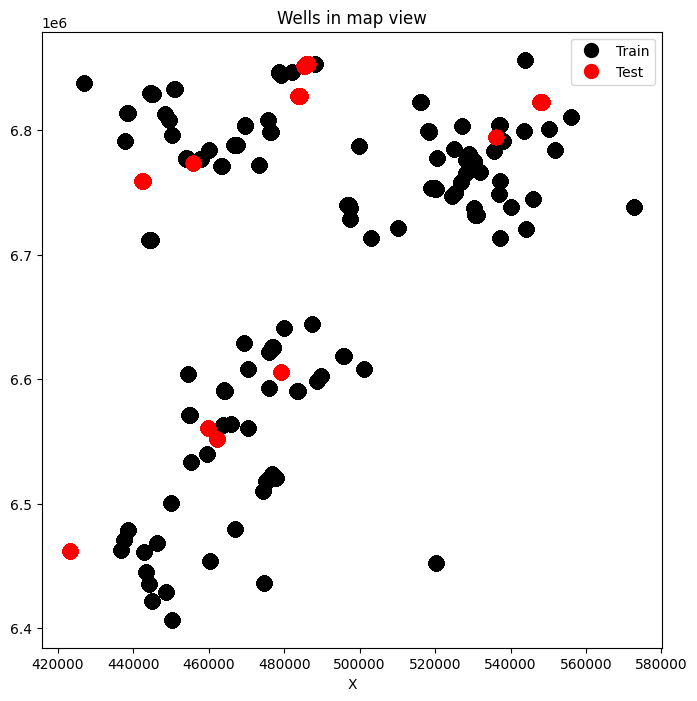

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(traindata['X_LOC'], traindata['Y_LOC'], '.k', ms=20, label='Train')
plt.plot(testdata['X_LOC'], testdata['Y_LOC'], '.r', ms=20, label='Test')
plt.xlabel('X')
plt.xlabel('X')
plt.title('Wells in map view')
plt.legend();
#We can immediately observe how test wells are scattered all around, an indication that we may want to use all train wells in our ML model.

We can immediately observe how test wells are scattered all around, an indication that we may want to use all train wells in our ML model.

### 1.1 categorical features

In [13]:
print("Formations:")
print(traindata['FORMATION'].value_counts())

Formations:
FORMATION
Utsira Fm.               172636
Kyrre Fm.                 94328
Lista Fm.                 71080
Heather Fm.               65041
Skade Fm.                 45983
                          ...  
Broom Fm.                   235
Intra Balder Fm. Sst.       177
Farsund Fm.                 171
Flekkefjord Fm.             118
Egersund Fm.                105
Name: count, Length: 69, dtype: int64


In [14]:
print("Groups:")
print(traindata['GROUP'].value_counts())

Groups:
GROUP
HORDALAND GP.       293155
SHETLAND GP.        234028
VIKING GP.          131999
ROGALAND GP.        131944
DUNLIN GP.          119085
NORDLAND GP.        111490
CROMER KNOLL GP.     52320
BAAT GP.             35823
VESTLAND GP.         26116
HEGRE GP.            13913
ZECHSTEIN GP.        12238
BOKNFJORD GP.         3125
ROTLIEGENDES GP.      2792
TYNE GP.              1205
Name: count, dtype: int64


### 1.2 Numerical features (logs)

understand the coverage across different wells and depths-check how many wells have at certain log (at least in part)

/tmp/ipykernel_340031/1984952498.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
/tmp/ipykernel_340031/1984952498.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(testdata.columns[2:], rotation=45)


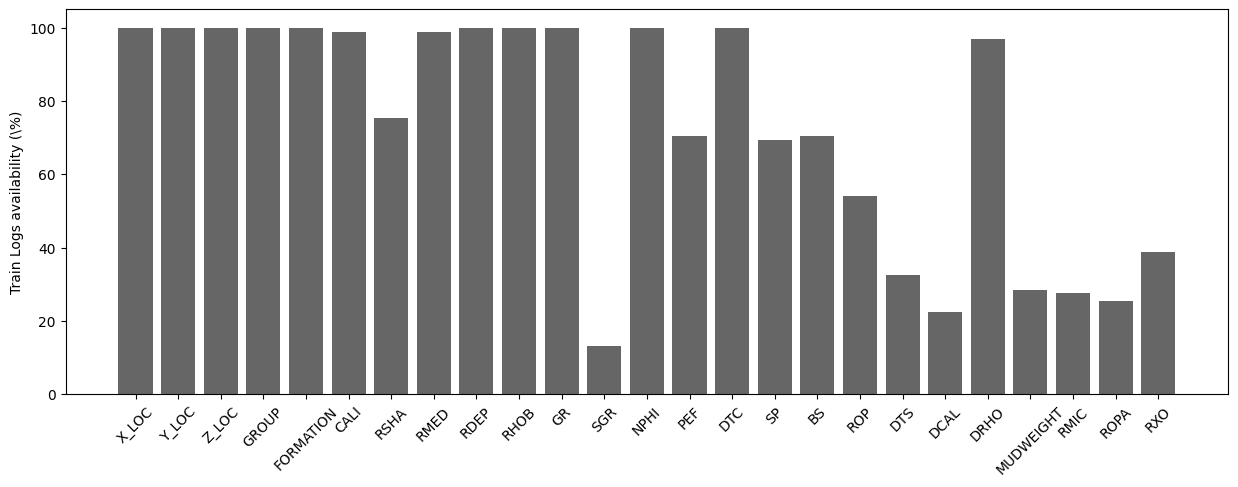

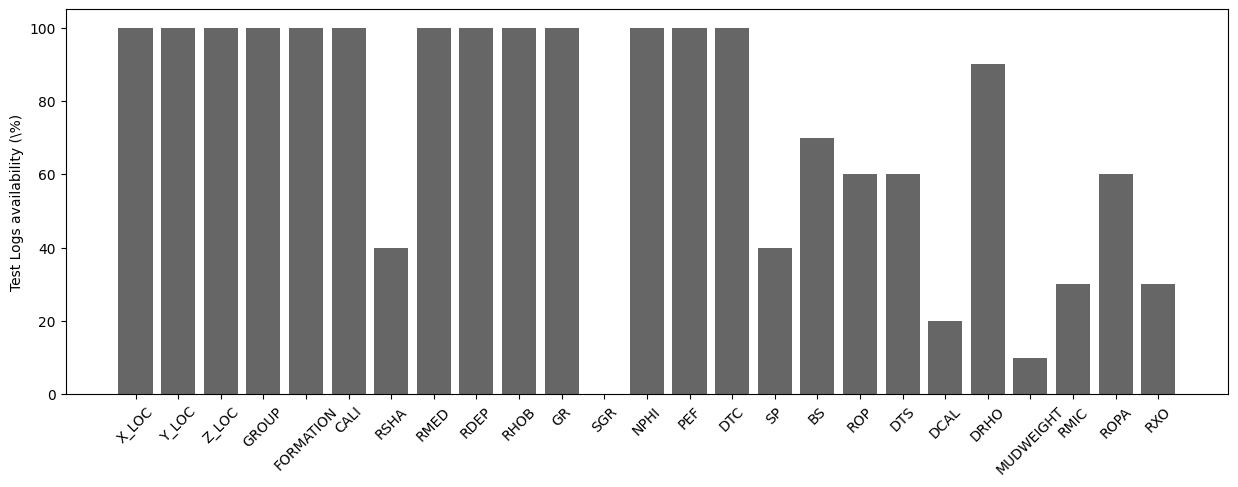

In [15]:
nlogs = 25 # Number of available numerical features (not all of them are real well logs)

# train
nwellstrain = traindata['WELL'].unique().size
occurences = np.zeros(nlogs)
for well in traindata['WELL'].unique():
    occurences += traindata[traindata['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), 
       height=(nwellstrain - occurences) / nwellstrain * 100.0, color='k', alpha=0.6)
ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Train Logs availability (\%)');

# test
nwellstest = testdata['WELL'].unique().size
occurences = np.zeros(nlogs)
for well in testdata['WELL'].unique():
    occurences += testdata[testdata['WELL'] == well].isna().all().astype(int).values[2:]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), 
       height=(nwellstest - occurences) / nwellstest * 100.0, color='k', alpha=0.6)
ax.set_xticklabels(testdata.columns[2:], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Test Logs availability (\%)');

very few wells have Spectral Gamma Ray (SGR) logs. Similarly shear sonic log (DTS), Differential Caliper Log (DCAL), Mud Weight (MUDWEIGHT), Micro Resisitivity (RMIC) and Shallow Resistivity (RXO) are also available in very few wells.

In [16]:
#overall availability of each log in percentage
traindata_logavailability = 100 - (traindata.isna().sum()/traindata.shape[0])[2:-2] * 100
testdata_logavailability = 100 - (testdata.isna().sum()/testdata.shape[0])[2:] * 100

In [17]:
traindata_logavailability

X_LOC         99.079462
Y_LOC         99.079462
Z_LOC         99.079462
GROUP         99.890817
FORMATION     88.296223
CALI          92.492424
RSHA          53.878178
RMED          96.668720
RDEP          99.058958
RHOB          86.222342
GR           100.000000
SGR            5.925019
NPHI          65.391013
PEF           57.384510
DTC           93.091650
SP            73.835017
BS            58.321280
ROP           45.712599
DTS           14.917673
DCAL          25.530132
DRHO          84.395362
MUDWEIGHT     27.009656
RMIC          15.049837
ROPA          16.430858
RXO           27.972996
dtype: float64

In [18]:
testdata_logavailability

X_LOC         99.956867
Y_LOC         99.956867
Z_LOC         99.956867
GROUP        100.000000
FORMATION     94.828418
CALI          95.873116
RSHA          28.582603
RMED          99.570863
RDEP          99.956867
RHOB          87.601070
GR           100.000000
SGR            0.000000
NPHI          76.062609
PEF           82.978521
DTC           99.398330
SP            48.708932
BS            48.955302
ROP           49.943708
DTS           31.596801
DCAL           9.880397
DRHO          81.555130
MUDWEIGHT     14.818037
RMIC           8.272776
ROPA          40.786338
RXO           21.820947
dtype: float64

/tmp/ipykernel_340031/3436171352.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
/tmp/ipykernel_340031/3436171352.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(testdata.columns[2:], rotation=45)


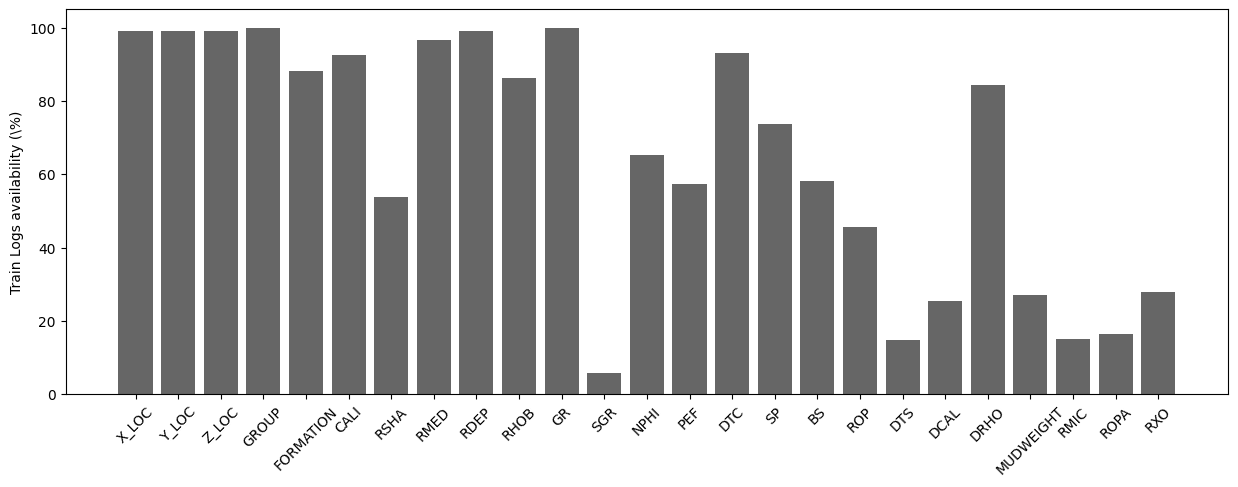

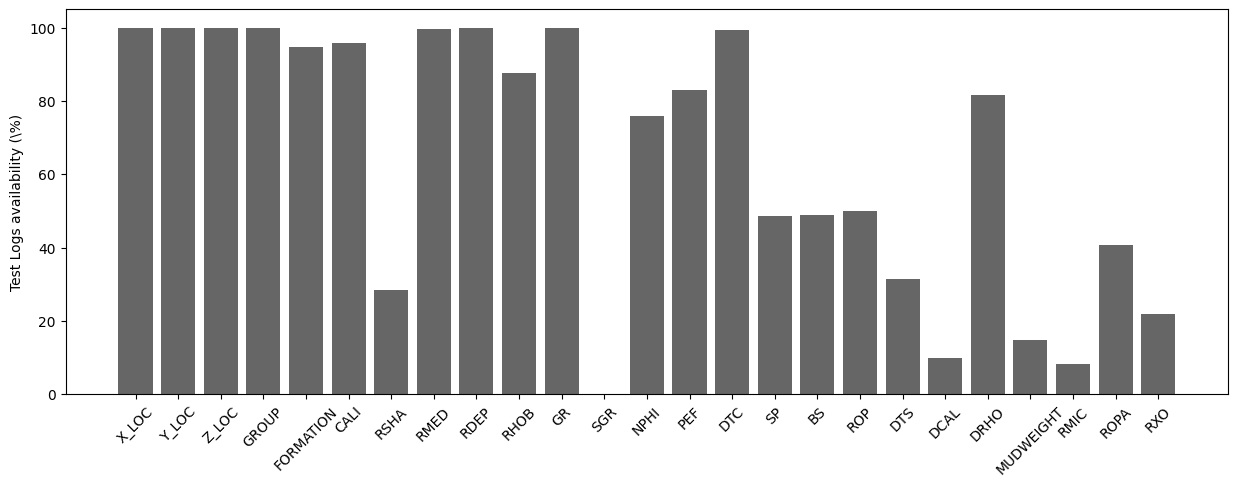

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), height=traindata_logavailability, color='k', alpha=0.6)
ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Train Logs availability (\%)');

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), height=testdata_logavailability, color='k', alpha=0.6)
ax.set_xticklabels(testdata.columns[2:], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Test Logs availability (\%)');

In [20]:
# numerical labels for the catagorical variables
nlithofacies = 12
lithofacies_names = {30000: 'Sandstone',
                     65030: 'SS/Shale',
                     65000: 'Shale',
                     80000: 'Dolomite',
                     74000: 'Tuff',
                     70000: 'Marl',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Coal', 
                     99000: 'Limestone',
                     90000: 'Anhydrite', 
                     93000: 'Basement'}
lithofacies_numbers = {30000: 0,
                       65030: 1,
                       65000: 2,
                       80000: 3,
                       74000: 4,
                       70000: 5,
                       70032: 6,
                       88000: 7,
                       86000: 8,
                       99000: 9,
                       90000: 10,
                       93000: 11}
lithofacies_colors =  {30000: 'y',
                       65030: '#96c136',
                       65000: 'g',
                       80000: '#5f5f5f',
                       74000: 'k',
                       70000: 'r',
                       70032: '#e5E5E5',
                       88000: 'c',
                       86000: 'b',
                       99000: 'm',
                       90000: '#fe9300',
                       93000: '#895347'}

trainlabels = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_names).value_counts()

## step2) ML Modeling preparation

the steps to follow:

* Selecting well logs to be used as features
* Encoding categorical variables
* Imputing missing values(other than DTS since we're going to predict it)
* divide data into train, test, and validation. Also, divide each into x(features) and y(label or target)


#### 2.1 selecting well logs 

1. drop the logs that are few in the wells since they have little information (RSHA, SGR, DCAL, MUDWEIGHT, RMIC, RXO), and use the rest as the features.

2. we can drop the confidence and the lithofacies_lithology since we are doing a regression task here to predict missing DTS values and add them back when performing the classification task

In [22]:

# drop the confidence and the lithofacies_lithology after the encoding to have already encoded data for the classification task afterward.
dropped_cols_train = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO'] 
dropped_cols_test = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO']

traindata_new = traindata.drop(dropped_cols_train, axis=1)
testdata_new = testdata.drop(dropped_cols_test, axis=1)

traindata_new.columns


Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DTS', 'DRHO', 'ROPA', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [23]:
testdata_new.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DTS', 'DRHO', 'ROPA'],
      dtype='object')

#### 2.2 Encoding categorical variables
Map categorical variables into numbers (we will use labels instead of one-hot encoding to keep the number of features to a reasonable number).

First of all we save a dictionary mapping well names to their numerical label that we can use later on when needed

In [24]:
trainwellcodes = dict(zip(traindata_new['WELL'].astype('category').cat.codes, traindata_new['WELL'] ) )
trainwellcodes1 = dict((v,k) for k,v in trainwellcodes.items()) # swap keys and values

traindata_new.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,29/6-1,4367.129001,444402.5625,6711929.0,-4323.834473,BAAT GP.,Ness Fm.,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,65030,1.0
357889,25/5-4,2271.328305,470379.0625,6608144.5,-2245.797852,ROGALAND GP.,Heimdal Fm.,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,65000,1.0
798724,34/10-35,2254.551000,463384.4375,6771048.5,-2231.373535,SHETLAND GP.,Vaale Fm.,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,65000,1.0
653894,31/4-5,1560.404796,503115.2500,6713756.5,-1535.076538,HORDALAND GP.,Utsira Fm.,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,65000,1.0
777890,34/10-21,2960.842403,454129.1250,6777267.5,-2931.367432,VIKING GP.,Draupne Fm.,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,65000,1.0


In [25]:
traindata_new['GROUP'] = traindata_new['GROUP'].astype('category').cat.codes 
traindata_new['FORMATION'] = traindata_new['FORMATION'].astype('category').cat.codes
traindata_new['WELL'] = traindata_new['WELL'].astype('category').cat.codes

testdata_new['GROUP'] = testdata_new['GROUP'].astype('category').cat.codes 
testdata_new['FORMATION'] = testdata_new['FORMATION'].astype('category').cat.codes
testdata_new['WELL'] = testdata_new['WELL'].astype('category').cat.codes

traindata_new.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,65030,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,65000,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,65000,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,65000,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,65000,1.0


In [26]:
testdata_new.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA
58325,4,2704.146001,442427.78125,6759350.0,-2678.143066,7,20,NaN,1.708669,1.642331,...,44.258583,NaN,NaN,106.073967,NaN,NaN,NaN,NaN,NaN,NaN
47318,4,1029.410001,442443.31250,6759397.0,-1004.394836,5,39,17.437500,0.805198,0.714092,...,27.667377,NaN,NaN,145.537094,52.655102,NaN,NaN,NaN,NaN,NaN
89577,5,3304.384008,455817.15625,6773617.5,-3280.011963,0,24,9.021601,15.753310,9.580315,...,55.389893,0.255603,7.247541,85.124283,65.718002,NaN,NaN,NaN,0.024029,NaN
8254,0,1736.604001,423240.84375,6461865.5,-1711.539917,4,39,13.834978,0.716035,0.737703,...,63.814404,0.476076,2.729652,149.066986,30.521828,NaN,44.139633,NaN,0.074790,NaN
85469,5,2679.968008,455772.75000,6773613.5,-2657.644531,7,20,12.993542,1.689202,1.425493,...,59.613777,0.328835,3.202121,104.223602,76.657280,NaN,NaN,NaN,0.099000,NaN


map the lithofacies labels into consecutive numbers

In [27]:
traindata_new.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,65030,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,65000,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,65000,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,65000,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,65000,1.0


In [28]:
traindata_new['FORCE_2020_LITHOFACIES_LITHOLOGY'] = traindata_new['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_numbers)
traindata_new.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,1,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,2,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,2,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,2,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,2,1.0


#### 2.3 Imputing missing values(other than DTS since we're going to predict it)
Fill the missing values using values above and below.

In [29]:
# remove DTS to do the filling for other logs then add it backagain
dropped_cols_train2 = ['DTS']
dropped_cols_test2 = ['DTS']

traindata_noDTS = traindata_new.drop(dropped_cols_train2, axis=1)
testdata_noDTS = testdata_new.drop(dropped_cols_test2, axis=1)

traindata_noDTS.columns


Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [30]:
testdata_noDTS.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA'],
      dtype='object')

In [31]:
traindata_noDTS.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,0.243135,113.754364,92.285614,52.642662,NaN,NaN,-0.014605,NaN,1,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,NaN,6.155957,101.428360,84.138863,12.250001,NaN,0.042459,NaN,2,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,NaN,11.167521,107.851089,22.276651,NaN,NaN,0.129825,NaN,2,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,NaN,149.761688,107.608055,NaN,NaN,0.017562,NaN,2,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,0.336660,10.739023,98.038651,32.000000,NaN,NaN,0.033609,NaN,2,1.0


In [32]:
testdata_noDTS.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA
58325,4,2704.146001,442427.78125,6759350.0,-2678.143066,7,20,NaN,1.708669,1.642331,NaN,44.258583,NaN,NaN,106.073967,NaN,NaN,NaN,NaN,NaN
47318,4,1029.410001,442443.31250,6759397.0,-1004.394836,5,39,17.437500,0.805198,0.714092,NaN,27.667377,NaN,NaN,145.537094,52.655102,NaN,NaN,NaN,NaN
89577,5,3304.384008,455817.15625,6773617.5,-3280.011963,0,24,9.021601,15.753310,9.580315,2.495265,55.389893,0.255603,7.247541,85.124283,65.718002,NaN,NaN,0.024029,NaN
8254,0,1736.604001,423240.84375,6461865.5,-1711.539917,4,39,13.834978,0.716035,0.737703,1.898581,63.814404,0.476076,2.729652,149.066986,30.521828,NaN,44.139633,0.074790,NaN
85469,5,2679.968008,455772.75000,6773613.5,-2657.644531,7,20,12.993542,1.689202,1.425493,2.386735,59.613777,0.328835,3.202121,104.223602,76.657280,NaN,NaN,0.099000,NaN


In [34]:
# Impute missing values without DTS 
traindata_noDTS = traindata_noDTS.fillna(method='pad')
testdata_noDTS = testdata_noDTS.fillna(method='pad')

traindata_noDTS = traindata_noDTS.fillna(method='backfill')
testdata_noDTS = testdata_noDTS.fillna(method='backfill')

print('% Remaining missing values in train data:')
print(traindata_noDTS.isna().sum()/traindata_noDTS.shape[0] * 100)

print('% Remaining missing values in test data:')
print(testdata_noDTS.isna().sum()/testdata_noDTS.shape[0] * 100)

/tmp/ipykernel_340031/3297669180.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  traindata_noDTS = traindata_noDTS.fillna(method='pad')
/tmp/ipykernel_340031/3297669180.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  testdata_noDTS = testdata_noDTS.fillna(method='pad')
/tmp/ipykernel_340031/3297669180.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  traindata_noDTS = traindata_noDTS.fillna(method='backfill')


% Remaining missing values in train data:
WELL                                 0.0
DEPTH_MD                             0.0
X_LOC                                0.0
Y_LOC                                0.0
Z_LOC                                0.0
GROUP                                0.0
FORMATION                            0.0
CALI                                 0.0
RMED                                 0.0
RDEP                                 0.0
RHOB                                 0.0
GR                                   0.0
NPHI                                 0.0
PEF                                  0.0
DTC                                  0.0
SP                                   0.0
BS                                   0.0
ROP                                  0.0
DRHO                                 0.0
ROPA                                 0.0
FORCE_2020_LITHOFACIES_LITHOLOGY     0.0
FORCE_2020_LITHOFACIES_CONFIDENCE    0.0
dtype: float64
% Remaining missing values in test data:


/tmp/ipykernel_340031/3297669180.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  testdata_noDTS = testdata_noDTS.fillna(method='backfill')


In [35]:
traindata_noDTS.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,0.243135,113.754364,92.285614,52.642662,8.500000,8.782885,-0.014605,11.211997,1,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,0.179912,6.155957,101.428360,84.138863,12.250001,19.168833,0.042459,11.211997,2,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,0.338941,11.167521,107.851089,22.276651,6.000000,10.629552,0.129825,10.979708,2,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,0.375214,2.674787,149.761688,107.608055,8.500000,23.613140,0.017562,26.532345,2,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,0.336660,10.739023,98.038651,32.000000,8.500000,10.629552,0.033609,10.979708,2,1.0


In [36]:
testdata_noDTS.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA
58325,4,2704.146001,442427.78125,6759350.0,-2678.143066,7,20,17.467648,1.708669,1.642331,2.598195,44.258583,0.237309,4.508837,106.073967,46.724998,8.5,24.596689,0.028794,21.611032
47318,4,1029.410001,442443.31250,6759397.0,-1004.394836,5,39,17.437500,0.805198,0.714092,2.598195,27.667377,0.237309,4.508837,145.537094,52.655102,8.5,24.596689,0.028794,21.611032
89577,5,3304.384008,455817.15625,6773617.5,-3280.011963,0,24,9.021601,15.753310,9.580315,2.495265,55.389893,0.255603,7.247541,85.124283,65.718002,8.5,24.596689,0.024029,21.611032
8254,0,1736.604001,423240.84375,6461865.5,-1711.539917,4,39,13.834978,0.716035,0.737703,1.898581,63.814404,0.476076,2.729652,149.066986,30.521828,17.5,44.139633,0.074790,12.159813
85469,5,2679.968008,455772.75000,6773613.5,-2657.644531,7,20,12.993542,1.689202,1.425493,2.386735,59.613777,0.328835,3.202121,104.223602,76.657280,8.5,24.596689,0.099000,21.611032


In [37]:
# Adding back the DTS column to the train and test dataset
traindata_DTSback = traindata_noDTS.copy()
traindata_DTSback['DTS'] = traindata_new['DTS']


testdata_DTSback = testdata_noDTS.copy()
testdata_DTSback['DTS'] = testdata_new['DTS']

In [38]:
traindata_DTSback.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE', 'DTS'],
      dtype='object')

In [39]:
testdata_DTSback.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA', 'DTS'],
      dtype='object')

In [40]:
traindata_DTSback.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,DTS
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,8.500000,8.782885,-0.014605,11.211997,1,1.0,NaN
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,19.168833,0.042459,11.211997,2,1.0,NaN
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,6.000000,10.629552,0.129825,10.979708,2,1.0,NaN
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,2.674787,149.761688,107.608055,8.500000,23.613140,0.017562,26.532345,2,1.0,NaN
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,8.500000,10.629552,0.033609,10.979708,2,1.0,NaN


In [41]:
testdata_DTSback.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS
58325,4,2704.146001,442427.78125,6759350.0,-2678.143066,7,20,17.467648,1.708669,1.642331,...,44.258583,0.237309,4.508837,106.073967,46.724998,8.5,24.596689,0.028794,21.611032,NaN
47318,4,1029.410001,442443.31250,6759397.0,-1004.394836,5,39,17.437500,0.805198,0.714092,...,27.667377,0.237309,4.508837,145.537094,52.655102,8.5,24.596689,0.028794,21.611032,NaN
89577,5,3304.384008,455817.15625,6773617.5,-3280.011963,0,24,9.021601,15.753310,9.580315,...,55.389893,0.255603,7.247541,85.124283,65.718002,8.5,24.596689,0.024029,21.611032,NaN
8254,0,1736.604001,423240.84375,6461865.5,-1711.539917,4,39,13.834978,0.716035,0.737703,...,63.814404,0.476076,2.729652,149.066986,30.521828,17.5,44.139633,0.074790,12.159813,NaN
85469,5,2679.968008,455772.75000,6773613.5,-2657.644531,7,20,12.993542,1.689202,1.425493,...,59.613777,0.328835,3.202121,104.223602,76.657280,8.5,24.596689,0.099000,21.611032,NaN


In [42]:
#drop LITHOFACIES_LITHOLOGY and CONFIDENCE from train data 
dropped_cols_train3 = ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE']

traindata_DTSback1 = traindata_DTSback.drop(dropped_cols_train3, axis=1)


traindata_DTSback1.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA', 'DTS'],
      dtype='object')

In [43]:
traindata_DTSback1.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,76.702248,0.243135,113.754364,92.285614,52.642662,8.500000,8.782885,-0.014605,11.211997,NaN
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,65.750381,0.179912,6.155957,101.428360,84.138863,12.250001,19.168833,0.042459,11.211997,NaN
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,47.348957,0.338941,11.167521,107.851089,22.276651,6.000000,10.629552,0.129825,10.979708,NaN
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,60.921146,0.375214,2.674787,149.761688,107.608055,8.500000,23.613140,0.017562,26.532345,NaN
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,78.424255,0.336660,10.739023,98.038651,32.000000,8.500000,10.629552,0.033609,10.979708,NaN


 #### 2.4 divide data into train, test, and validation. Also, divide each into x(features) and y(label or target)

In [45]:
# Filter rows with missing DTS values and map indices to add back those rows after prediction 
traindata_DTSnan = traindata_DTSback1[traindata_DTSback1['DTS'].isna()] 
traindata_DTSnan['dt']=0 #to map indices 
testdata_DTSnan = testdata_DTSback[testdata_DTSback['DTS'].isna()]
testdata_DTSnan['dt']=1  # to map indices 

# Combine to form the prediction dataset (the data set that will have all the rows with missing DTS to predict)
prediction_data_dt = pd.concat([traindata_DTSnan, testdata_DTSnan], ignore_index=False)



/tmp/ipykernel_340031/1882528984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata_DTSnan['dt']=0 #to map indices
/tmp/ipykernel_340031/1882528984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata_DTSnan['dt']=1  # to map indices


In [46]:
prediction_data_dt.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS,dt
46677,2,2097.309998,438597.21875,6478960.0,-2075.190918,5,67,12.872721,0.687399,0.676957,...,0.470655,3.368679,136.319962,41.637798,8.500000,18.202183,-0.007911,8.825735,NaN,0
517065,39,4455.849586,497022.12500,6740000.0,-3152.685059,3,9,8.916540,4.751342,4.498936,...,0.245529,3.026458,76.873749,27.110792,8.500000,8.782885,0.010677,11.211997,NaN,0
1222,0,680.272000,437642.78125,6470973.0,-655.241455,6,-1,18.688061,1.647488,2.211359,...,0.765867,2.190347,142.881409,30.731005,26.000002,46.639454,-0.003213,8.825735,NaN,0
35586,3,1425.755190,479084.09375,6605459.0,-1403.686035,4,11,13.108953,1.156835,1.091297,...,0.586954,4.954788,140.197189,-0.048361,12.250001,24.596689,-0.002946,21.611032,NaN,1
826750,65,2854.192000,466812.93750,6788233.5,-2828.535889,9,62,17.633598,1.382325,1.715632,...,0.236806,4.161167,102.312492,-6.643493,8.375000,10.629552,0.001608,16.100000,NaN,0


In [48]:
# the same but without the dt column 
prediction_data= prediction_data_dt.drop(['dt'], axis=1)

prediction_data.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS
46677,2,2097.309998,438597.21875,6478960.0,-2075.190918,5,67,12.872721,0.687399,0.676957,...,60.997116,0.470655,3.368679,136.319962,41.637798,8.500000,18.202183,-0.007911,8.825735,NaN
517065,39,4455.849586,497022.12500,6740000.0,-3152.685059,3,9,8.916540,4.751342,4.498936,...,65.476456,0.245529,3.026458,76.873749,27.110792,8.500000,8.782885,0.010677,11.211997,NaN
1222,0,680.272000,437642.78125,6470973.0,-655.241455,6,-1,18.688061,1.647488,2.211359,...,70.028748,0.765867,2.190347,142.881409,30.731005,26.000002,46.639454,-0.003213,8.825735,NaN
35586,3,1425.755190,479084.09375,6605459.0,-1403.686035,4,11,13.108953,1.156835,1.091297,...,64.633644,0.586954,4.954788,140.197189,-0.048361,12.250001,24.596689,-0.002946,21.611032,NaN
826750,65,2854.192000,466812.93750,6788233.5,-2828.535889,9,62,17.633598,1.382325,1.715632,...,94.867714,0.236806,4.161167,102.312492,-6.643493,8.375000,10.629552,0.001608,16.100000,NaN


In [49]:
# Remove rows with missing DTS from training and testing datasets
traindata_DTS1 = traindata_DTSback1.dropna(subset=['DTS'])
testdata_DTS1 = testdata_DTSback.dropna(subset=['DTS'])

In [50]:
traindata_DTS1.sample(n=5, random_state=5)   

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS
1125316,92,2079.264358,550239.87500,6800627.0,-2047.053223,12,11,8.908797,19.435547,18.047159,...,118.336304,0.355987,5.459232,96.158424,42.049736,8.500,28.734827,0.006271,11.749605,177.965408
1039874,84,3219.167600,524979.68750,6784905.0,-3190.946533,12,23,12.000000,4.789091,3.191150,...,89.564613,0.319179,3.887024,86.954216,75.500000,8.500,19.425941,-0.011594,22.623297,165.246948
636333,49,1420.545638,537247.75000,6759164.0,-1380.468628,9,22,8.431274,2.980056,2.816480,...,55.354698,0.284904,4.570045,103.440788,142.334854,8.500,25.007446,0.015525,19.807735,208.995819
847076,66,4494.517584,499930.28125,6787691.0,-4469.795898,0,44,8.309304,7.231603,6.429649,...,70.743309,0.193604,4.930453,74.645851,0.000000,8.375,16.650108,-0.016802,5.100718,136.479080
1084601,88,3070.140000,516081.46875,6822422.0,-3043.931641,9,36,17.785101,1.078379,1.952352,...,31.248703,0.310442,4.065052,93.907234,-51.646549,17.500,11.525200,-0.018641,2.445973,194.765503


In [51]:
testdata_DTS1.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS
128640,8,3105.152467,548065.8750,6822795.0,-2987.244873,1,1,8.468116,5.759218,5.743709,...,45.127594,0.187736,2.252998,81.075356,65.462494,8.500000,15.890909,-0.005195,13.952950,136.020554
100430,6,3154.537975,485395.0625,6851997.0,-2923.795410,7,20,12.972853,1.327554,1.346255,...,97.614273,0.364483,8.645884,103.388535,65.462494,12.250001,39.115139,0.022987,33.399670,217.898010
133386,9,2669.133600,536235.6875,6794891.0,-2644.837646,7,34,8.871187,2.665847,2.506841,...,69.316360,0.215098,4.200181,84.333839,65.462494,8.500000,8.089251,-0.002802,9.295365,182.236343
136225,9,3100.661600,536229.2500,6794883.5,-3076.227295,9,13,8.514885,6.590688,6.570898,...,116.179222,0.364446,3.687437,82.033546,65.462494,8.500000,18.969988,-0.005739,17.958700,159.719849
109068,6,4467.969976,485968.1875,6852939.0,-3637.200928,7,37,12.366082,1.911570,2.023450,...,108.072182,0.250429,4.372849,91.048393,65.462494,12.250001,13.602925,-0.006872,25.009291,181.675293


In [52]:
#split training data into label(in this case DTS) and features  
x_train = traindata_DTS1.drop(['DTS'], axis=1)


x_train.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA'],
      dtype='object')

In [53]:
y_train = traindata_DTS1['DTS']

y_train.sample(n=5, random_state=5)

1125316    177.965408
1039874    165.246948
636333     208.995819
847076     136.479080
1084601    194.765503
Name: DTS, dtype: float64

In [54]:
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [55]:
#split test data into label(in this case DTS) and features
x_test = testdata_DTS1.drop(['DTS'], axis=1)


x_test.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DRHO', 'ROPA'],
      dtype='object')

In [56]:
y_test = testdata_DTS1['DTS']

y_test.sample(n=5, random_state=5)

128640    136.020554
100430    217.898010
133386    182.236343
136225    159.719849
109068    181.675293
Name: DTS, dtype: float64

In [58]:
x_pred = prediction_data.drop(['DTS'], axis=1)

x_pred.sample(n=5, random_state=5)

#for the prediction data we will predict the labels (missing DTS values)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA
46677,2,2097.309998,438597.21875,6478960.0,-2075.190918,5,67,12.872721,0.687399,0.676957,2.108723,60.997116,0.470655,3.368679,136.319962,41.637798,8.500000,18.202183,-0.007911,8.825735
517065,39,4455.849586,497022.12500,6740000.0,-3152.685059,3,9,8.916540,4.751342,4.498936,2.446016,65.476456,0.245529,3.026458,76.873749,27.110792,8.500000,8.782885,0.010677,11.211997
1222,0,680.272000,437642.78125,6470973.0,-655.241455,6,-1,18.688061,1.647488,2.211359,2.110986,70.028748,0.765867,2.190347,142.881409,30.731005,26.000002,46.639454,-0.003213,8.825735
35586,3,1425.755190,479084.09375,6605459.0,-1403.686035,4,11,13.108953,1.156835,1.091297,2.034766,64.633644,0.586954,4.954788,140.197189,-0.048361,12.250001,24.596689,-0.002946,21.611032
826750,65,2854.192000,466812.93750,6788233.5,-2828.535889,9,62,17.633598,1.382325,1.715632,2.480377,94.867714,0.236806,4.161167,102.312492,-6.643493,8.375000,10.629552,0.001608,16.100000


## step3) ML modelling

### 1. random forest 

Here I wanted to try the random forest model but training the model took a long time and the kernel was restarting every time in the middle of the grid searching, so instead I proceeded with NN.

In [ ]:
#random forest regressor 
rf = RandomForestRegressor(random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

#GridSearchCV to find the best parameters (hyperparameter tuning)
GS = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
GS.fit(x_train, y_train)


In [ ]:
# Best parameters and score
print(f"Best parameters: {GS.best_params_}")
print(f"Best score (negative MSE): {GR.best_score_}")


In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

In [ ]:
# Retrain using the best parameters 
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(x_train, y_train)

In [ ]:
# loss over validation 
y_val_pred = rf1.predict(x_val)

mse_val = mean_squared_error(y_val, y_pred_val)
print(f"Validation MSE: {mse_val}")

rmse_val = np.sqrt(mse_val)
print(f"Validation RMSE: {rmse_val}")

r2_val = r2_score(y_val, y_pred_val)
print(f"Validation R²: {r2_val}")



In [ ]:
#predict missing DTS values 
miss_DTS = rf1.predict(x_pred)

In [ ]:
# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

In [ ]:
predicted_dts_values = model.predict(X_pred1)

In [ ]:
y_val_pred = rf.predict(x_val_scaled)
y_test_pred = rf.predict(x_test_scaled)

print("Validation MSE:", mean_squared_error(y_val, y_val_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val_split, y_val_pred)
r2 = r2_score(y_val_split, y_val_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

### 2. predictions using 3-layer NN
1. model <br>
The model used here is a 3-layer neural network(MLP) with ReLU activation function since it simplifies the backpropagation process, doesn't have the vanishing problem, and it is commonly used in NN <br>
2. metric  of goodness (loss) <br>
Used MSE loss since it's a regression problem to predict continuous values. <br>
3. optimization <br>
Used Adam optimizer since it combines the best properties of the AdaGrad and RMSProp optimizers and has an adaptive learning rate. <br>
4. hyperparameter tuning <br>
   . tried two learning rates:<br>
    0.1 which the model had good training loss but the validation loss was initially big (around 2000) and increased rather than decreasing.<br>
    0.01 which the model performed better regarding the validation loss but still was larger than the training loss<br>
    
   . tried to increase/decrease the number of layers: <br>
   tried 2-layer NN, again training loss was good but the validation loss started initially at a big number (around 400) and decreased but kind of plateaued at still big loss <br>
   tried 4-layer NN but that didn't improve either of the losses rather the validation loss started initially at a big number (600) and decreased very slowly and started to plateau and fluctuate still at a big number even with different epochs <br>
   
   .tried different number of epochs: <br>
   tried 250 and 500 and 700 but in general there were no apparent effects, the training loss was small and decreased fast then plateaued in both cases, validation loss decreased slowly and fluctuated at certain epochs regardless. <br>
   
   .tried dropout: <br>
   as can be seen in the code tried to add dropout with different percentages in all 3 architectures (2 NN, 3 NN, 4 NN), I tried to fix the data overfitting that can be seen but doing so did not improve (not better than what is activated in the code) <br>
   .
   

In [59]:
#(torch.from_numpy build upon instead of making copies)
# Scaling pre-processing
scaler = StandardScaler()
scaler.fit(x_train)

# Define Train Set
x_train_tens = torch.from_numpy(scaler.transform(x_train.values)).float().to(device)
y_train_tens = torch.from_numpy(y_train.values).float().to(device)
traindataset_tens = TensorDataset(x_train_tens, y_train_tens)

# Define Valid Set
x_valid_tens = torch.from_numpy(scaler.transform(x_val.values)).float().to(device)
y_valid_tens = torch.from_numpy(y_val.values).float().to(device)
validdataset_tens = TensorDataset(x_valid_tens, y_valid_tens)

# Define test Set
x_test_tens = torch.from_numpy(scaler.transform(x_test.values)).float().to(device)
y_test_tens = torch.from_numpy(y_test.values).float().to(device)
testdataset_tens = TensorDataset(x_test_tens, y_test_tens)

#prediction data
x_pred_tens = torch.from_numpy(scaler.transform(x_pred.values)).float().to(device)

# Use Pytorch's functionality to load data in batches.
train_loader1 = DataLoader(traindataset_tens, batch_size=64, shuffle=True)
valid_loader1 = DataLoader(validdataset_tens, batch_size=64, shuffle=False)
test_loader1 = DataLoader(testdataset_tens, batch_size=64, shuffle=False)

/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [61]:
#2-layer nn

#class NeuralNetwork(torch.nn.Module):
    
    # def __init__(self, input_size):   #def __init__(self, input_size, hidden_size, output_size):
      #  super(NeuralNetwork, self).__init__()
       # self.linear1 = torch.nn.Linear(input_size, 32)
        #self.activation= torch.nn.ReLU()
       # self.linear2 = torch.nn.Linear(32, 1)
       
         
    # def forward(self, x):
     #   x=self.linear1(x)
      #  x=self.activation(x)
       # x=self.linear2(x) 
       # return x

In [62]:
torch.manual_seed(42)  # for reproducability 

class NeuralNetwork(torch.nn.Module):
    
     def __init__(self, input_size):   #def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        #self.linear1 = torch.nn.Linear(input_size, 128)
        self.linear1 = torch.nn.Linear(input_size, 64)
        self.activation1= torch.nn.ReLU()
        #self.dropout1 = torch.nn.Dropout(p=0.2)
        self.linear2 = torch.nn.Linear(64, 32)
        #self.linear2 = torch.nn.Linear(128, 64)
        self.activation2= torch.nn.ReLU()
        #self.dropout2 = torch.nn.Dropout(p=0.3)
        self.linear3 = torch.nn.Linear(32, 1)
        #self.linear3 = torch.nn.Linear(64, 32) 
        self.activation3= torch.nn.ReLU()
        #self.dropout3 = torch.nn.Dropout(p=0.4)
        #self.linear4 = torch.nn.Linear(32, 1) 
        
         
     def forward(self, x):
        x=self.linear1(x)
        x=self.activation1(x)
        #x=self.dropout1(x)
        x=self.linear2(x) 
        x=self.activation2(x)
        #x=self.dropout2(x)
        x=self.linear3(x)
        #x=self.activation3(x)
        #x=self.dropout3(x)
        #x=self.linear4(x)
        return x

 

In [63]:
nn_model = NeuralNetwork(input_size=x_train.shape[1]).to(device)

criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(nn_model.parameters(), lr=0.01, betas=(0.9, 0.999))
losses_train = []
losses_valid = []
epochs = 250  
for epoch in range(epochs):
    nn_model.train() 
    train_loss = 0
    for inputs, targets in train_loader1:
        optimizer.zero_grad()  
        outputs = nn_model(inputs)  # Forward pass
        loss = criterion(outputs, targets.unsqueeze(1))  
        loss.backward()  # Backward pass
        optimizer.step()
        train_loss += loss.item()
    losses_train.append(train_loss)
        
    nn_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  
        for val_inputs, val_targets in valid_loader1:
            val_outputs = nn_model(val_inputs)
            loss = criterion(val_outputs, val_targets.unsqueeze(1))
            val_loss += loss.item()
        losses_valid.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train loss: {loss / len(train_loader1)} ,Validation Loss: {val_loss / len(valid_loader1)}")


Epoch 1/250, Train loss: 0.23214255273342133 ,Validation Loss: 462.2548617967319
Epoch 2/250, Train loss: 0.08697392046451569 ,Validation Loss: 459.15927362966016
Epoch 3/250, Train loss: 0.09305164963006973 ,Validation Loss: 378.3620206811926
Epoch 4/250, Train loss: 0.12162785977125168 ,Validation Loss: 331.7483276465
Epoch 5/250, Train loss: 0.05354759842157364 ,Validation Loss: 313.0196099263844
Epoch 6/250, Train loss: 0.05499344691634178 ,Validation Loss: 303.6182550982241
Epoch 7/250, Train loss: 0.09049671143293381 ,Validation Loss: 290.56274527944487
Epoch 8/250, Train loss: 0.044758740812540054 ,Validation Loss: 281.04842656173986
Epoch 9/250, Train loss: 0.06004759296774864 ,Validation Loss: 281.40494114662704
Epoch 10/250, Train loss: 0.05789785459637642 ,Validation Loss: 265.6940230345115
Epoch 11/250, Train loss: 0.04722001031041145 ,Validation Loss: 278.02484357226024
Epoch 12/250, Train loss: 0.0953051820397377 ,Validation Loss: 261.8635028098529
Epoch 13/250, Train los

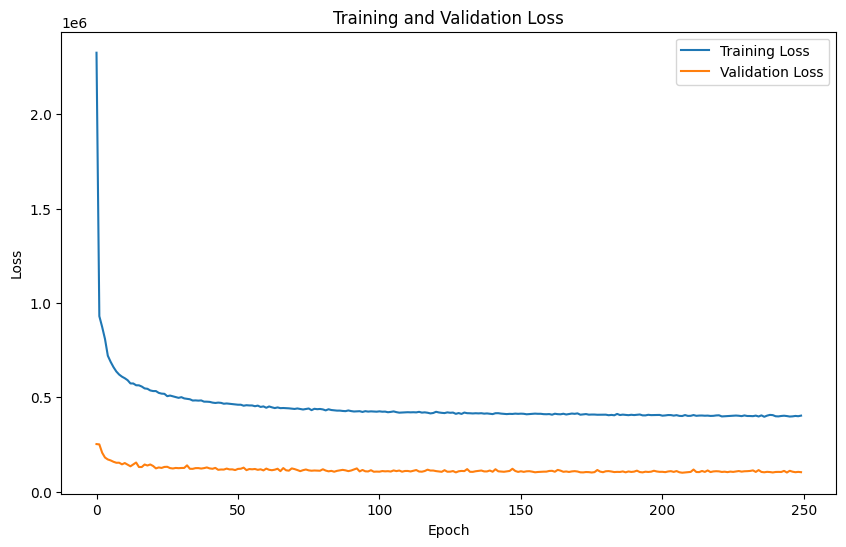

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_valid, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The consistent decrease in the learning rate indicates that the model is learning the training data well although there are small fluctuations.

The validation loss starts extremely high at 462.25 and decreases over time. While it drops significantly in the initial epochs, it stabilizes around a range that, while much lower than the initial loss, is still relatively high compared to the training loss. Also, it shows more fluctuation. It can be said that the model gradually improves its generalization to new data that hasn't been seen during training.

This significant difference between the training loss being this small and the validation loss being large suggest overfitting, by means the model is learning the training data very well but not performing that well on validation, that is why I tried dropout and increasing layer or decreasing them but no better results than the 3layer nn used in the code, one thing that improved the validation loss (to the numbers shown from this code) was the 0.01 learning rate.

maybe using regularizing techniques other than dropout will help more in improving the performance.

In [65]:
#predict missing DTS values 
predictions1=[]
nn_model.eval()  
with torch.no_grad():  
    predictions = nn_model(x_pred_tens).squeeze().cpu().numpy()
    predictions1=predictions.tolist()
   

In [66]:
len(predictions1) 

1089464

In [67]:
prediction_data_dt['DTS1']=predictions1

In [68]:
prediction_data_dt

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS,dt,DTS1
0,0,494.528000,437641.96875,6470972.5,-469.501831,6,-1,19.480835,1.611410,1.798681,...,20.915468,161.131180,24.612379,26.000002,34.636410,-0.574928,8.825735,NaN,0,355.875793
1,0,494.680000,437641.96875,6470972.5,-469.653809,6,-1,19.468800,1.618070,1.795641,...,19.383013,160.603470,23.895531,26.000002,34.636410,-0.570188,8.825735,NaN,0,357.806793
2,0,494.832000,437641.96875,6470972.5,-469.805786,6,-1,19.468800,1.626459,1.800733,...,22.591518,160.173615,23.916357,26.000002,34.779556,-0.574245,8.825735,NaN,0,349.367462
3,0,494.984000,437641.96875,6470972.5,-469.957794,6,-1,19.459282,1.621594,1.801517,...,32.191910,160.149429,23.793688,26.000002,39.965164,-0.586315,8.825735,NaN,0,332.727631
4,0,495.136000,437641.96875,6470972.5,-470.109772,6,-1,19.453100,1.602679,1.795299,...,38.495632,160.128342,24.104078,26.000002,57.483765,-0.597914,8.825735,NaN,0,323.669769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132507,8,3694.912467,547917.25000,6822794.5,-3555.816162,1,0,8.553368,9.208500,8.533600,...,4.882754,70.068115,65.462494,8.500000,15.083316,0.105254,15.650532,NaN,1,154.837387
132508,8,3695.064467,547917.25000,6822794.5,-3555.966064,1,0,8.558637,9.208500,8.533600,...,4.906672,70.068115,65.462494,8.500000,15.132172,0.105553,15.471996,NaN,1,155.095047
132509,8,3695.216467,547917.18750,6822794.5,-3556.116211,1,0,8.572794,9.208500,8.533600,...,4.934236,70.068115,65.462494,8.500000,15.436068,0.101996,15.124790,NaN,1,155.808380
132510,8,3695.368467,547917.18750,6822794.5,-3556.116211,1,0,8.598366,9.208500,8.533600,...,5.106630,70.068115,65.462494,8.500000,15.783777,0.102644,14.762804,NaN,1,155.753372


In [69]:
testdata['DTS'].isna().sum()

93566

In [71]:
#adding predicted values back into the train, test data set 
for index, row in prediction_data_dt.iterrows():
    if row['dt']==0:
        traindata_DTSback.at[index, 'DTS']=row['DTS1']
    elif row['dt']==1:
        testdata_DTSback.at[index, 'DTS']=row['DTS1']
        


In [73]:
traindata_DTSback

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,DTS
0,0,494.5280,437641.96875,6470972.5,-469.501831,6,-1,19.480835,1.611410,1.798681,...,20.915468,161.131180,24.612379,26.000002,34.636410,-0.574928,8.825735,2,1.0,355.875793
1,0,494.6800,437641.96875,6470972.5,-469.653809,6,-1,19.468800,1.618070,1.795641,...,19.383013,160.603470,23.895531,26.000002,34.636410,-0.570188,8.825735,2,1.0,357.806793
2,0,494.8320,437641.96875,6470972.5,-469.805786,6,-1,19.468800,1.626459,1.800733,...,22.591518,160.173615,23.916357,26.000002,34.779556,-0.574245,8.825735,2,1.0,349.367462
3,0,494.9840,437641.96875,6470972.5,-469.957794,6,-1,19.459282,1.621594,1.801517,...,32.191910,160.149429,23.793688,26.000002,39.965164,-0.586315,8.825735,2,1.0,332.727631
4,0,495.1360,437641.96875,6470972.5,-470.109772,6,-1,19.453100,1.602679,1.795299,...,38.495632,160.128342,24.104078,26.000002,57.483765,-0.597914,8.825735,2,1.0,323.669769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,97,3169.3124,444920.37500,6421578.0,-3107.844727,11,7,8.423170,0.791694,0.881417,...,4.586425,99.159462,22.040783,8.500000,27.674368,-0.001763,26.673708,0,2.0,152.960220
1170507,97,3169.4644,444920.37500,6421578.0,-3107.844727,11,7,8.379244,0.791694,0.881417,...,7.019858,99.159462,22.040783,8.500000,28.024338,-0.007600,26.840818,1,2.0,152.362823
1170508,97,3169.6164,444920.37500,6421578.0,-3107.844727,11,7,8.350248,0.791694,0.881417,...,9.049782,99.159462,22.040783,8.500000,28.091282,-0.018297,27.007942,1,2.0,149.600281
1170509,97,3169.7684,444920.37500,6421578.0,-3107.844727,11,7,8.313779,0.791694,0.881417,...,8.903917,99.159462,22.040783,8.500000,28.019775,-0.011438,27.175179,1,2.0,146.641220


In [74]:
 testdata_DTSback

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,GR,NPHI,PEF,DTC,SP,BS,ROP,DRHO,ROPA,DTS
0,0,480.628001,423244.50000,6461862.5,-455.624420,5,-1,19.2031,1.613886,1.513937,...,72.078377,0.551575,55.815659,174.347092,35.525719,17.5,96.461990,-0.538873,12.159813,310.519470
1,0,480.780001,423244.50000,6461862.5,-455.776428,5,-1,19.2031,1.574376,1.480188,...,72.147697,0.547566,41.862537,176.112915,36.158520,17.5,96.454399,-0.539232,12.159813,326.511963
2,0,480.932001,423244.50000,6461862.5,-455.928436,5,-1,19.2031,1.436627,1.469700,...,75.074219,0.551840,38.587872,177.662476,36.873703,17.5,96.446686,-0.540830,12.159813,336.123871
3,0,481.084001,423244.50000,6461862.5,-456.080444,5,-1,19.2031,1.276094,1.469341,...,80.735229,0.552511,41.417999,177.437714,37.304054,17.5,161.170166,-0.543943,12.159813,335.655304
4,0,481.236001,423244.53125,6461862.5,-456.232422,5,-1,19.2031,1.204704,1.466462,...,81.665024,0.566789,49.471237,176.797653,37.864922,17.5,172.489120,-0.542104,12.159813,327.732269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136781,9,3224.389600,536225.93750,6794880.5,-3199.876465,0,25,8.4978,6.231942,7.027874,...,60.644516,0.178304,5.580282,67.790977,65.462494,8.5,26.615782,0.063478,33.523922,118.669212
136782,9,3224.541600,536225.93750,6794880.5,-3200.028320,0,25,8.4978,6.038777,6.875511,...,60.317150,0.179475,5.532178,67.895126,65.462494,8.5,25.647141,0.056791,32.643795,118.468925
136783,9,3224.693600,536225.93750,6794880.5,-3200.180176,0,25,8.4978,5.503983,6.338658,...,63.907867,0.181352,4.766746,68.217995,65.462494,8.5,23.929407,0.002499,31.763380,118.163177
136784,9,3224.845600,536225.93750,6794880.5,-3200.332031,0,25,8.4978,4.895551,5.666211,...,64.572060,0.182943,4.723001,68.701576,65.462494,8.5,22.737293,0.003363,30.884350,117.655937


In [75]:
 traindata_DTSback.isna().sum()/prediction_data_dt.shape[0] * 100

WELL                                 0.0
DEPTH_MD                             0.0
X_LOC                                0.0
Y_LOC                                0.0
Z_LOC                                0.0
GROUP                                0.0
FORMATION                            0.0
CALI                                 0.0
RMED                                 0.0
RDEP                                 0.0
RHOB                                 0.0
GR                                   0.0
NPHI                                 0.0
PEF                                  0.0
DTC                                  0.0
SP                                   0.0
BS                                   0.0
ROP                                  0.0
DRHO                                 0.0
ROPA                                 0.0
FORCE_2020_LITHOFACIES_LITHOLOGY     0.0
FORCE_2020_LITHOFACIES_CONFIDENCE    0.0
DTS                                  0.0
dtype: float64

In [76]:
 testdata_DTSback.isna().sum()/prediction_data_dt.shape[0] * 100

WELL         0.0
DEPTH_MD     0.0
X_LOC        0.0
Y_LOC        0.0
Z_LOC        0.0
GROUP        0.0
FORMATION    0.0
CALI         0.0
RMED         0.0
RDEP         0.0
RHOB         0.0
GR           0.0
NPHI         0.0
PEF          0.0
DTC          0.0
SP           0.0
BS           0.0
ROP          0.0
DRHO         0.0
ROPA         0.0
DTS          0.0
dtype: float64

# Q1-part2: Facies Classification with predicted DTS 

### Data augmentation

I am going to start from here since all the previous data processing steps are done in part1 

In [77]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

def add_suffix(elements, string):
    return [el + string for el in elements]

In [78]:
# Choose which features to augument 
aug_labels = list(traindata_DTSback.columns)
aug_labels.remove('WELL')
aug_labels.remove('FORCE_2020_LITHOFACIES_LITHOLOGY')
aug_labels.remove('FORCE_2020_LITHOFACIES_CONFIDENCE')

aug_labels

['DEPTH_MD',
 'X_LOC',
 'Y_LOC',
 'Z_LOC',
 'GROUP',
 'FORMATION',
 'CALI',
 'RMED',
 'RDEP',
 'RHOB',
 'GR',
 'NPHI',
 'PEF',
 'DTC',
 'SP',
 'BS',
 'ROP',
 'DRHO',
 'ROPA',
 'DTS']

In [79]:
print(f'Shape of datasets before augmentation {traindata_DTSback.loc[:, aug_labels].shape, testdata_DTSback.loc[:, aug_labels].shape}')

aug_traindata = augment_features(traindata_DTSback.loc[:, aug_labels].values, 
                                 traindata_DTSback['WELL'], traindata_DTSback['DEPTH_MD'])
aug_testdata = augment_features(testdata_DTSback.loc[:, aug_labels].values, 
                                testdata_DTSback['WELL'], testdata_DTSback['DEPTH_MD'])

print(f'Shape of datasets after augmentation {aug_traindata.shape, aug_testdata.shape}')

Shape of datasets before augmentation ((1170511, 20), (136786, 20))
Shape of datasets after augmentation ((1170511, 80), (136786, 80))


In [80]:
aug_newlabels = add_suffix(aug_labels, '_AVE1') + add_suffix(aug_labels, '_AVE2') + \
                add_suffix(aug_labels, '_AVE3') + add_suffix(aug_labels, '_DIFF')

aug_traindata = pd.DataFrame(aug_traindata, columns=aug_newlabels)
aug_testdata = pd.DataFrame(aug_traindata, columns=aug_newlabels)

### ML modelling

In [81]:
A = np.load('../../data/welllogs/penalty_matrix.npy')   # Penalty matrix used for scoring

In [82]:
def force_score(y_true, y_pred, A):
    """
    FORCE score
    """
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        (y_true[i], y_pred[i])
        S -= A[y_true[i], y_pred[i]]
    return S / y_true.shape[0]

In [83]:
def show_evaluation(pred, true):
    print(f'Force score is: {force_score(true.values, pred, A)}')
    print(f'Accuracy is: {accuracy_score(true, pred)}')
    print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [84]:
random.seed(15)
validnwells = 10
validwellnames = random.sample(list(trainwellnames), validnwells)
validwelllabels = [trainwellcodes1[wellname] for wellname in validwellnames]
validnwellcodes = dict((v,k) for k,v in zip(validwellnames, validwelllabels))
validnwellcodes1 = dict((v,k) for k,v in validnwellcodes.items()) # swap keys and values
validwellnames, validnwellcodes1

(['25/4-5',
  '15/9-15',
  '34/12-1',
  '35/9-6 S',
  '16/1-6 A',
  '25/11-19 S',
  '25/6-2',
  '15/9-17',
  '16/10-3',
  '35/3-7 S'],
 {'25/4-5': 26,
  '15/9-15': 1,
  '34/12-1': 66,
  '35/9-6 S': 94,
  '16/1-6 A': 4,
  '25/11-19 S': 20,
  '25/6-2': 30,
  '15/9-17': 2,
  '16/10-3': 7,
  '35/3-7 S': 87})

In [85]:
validdata = traindata_DTSback[traindata_DTSback['WELL'].isin(validwelllabels)].reset_index(drop=True)
traindata = traindata_DTSback[~traindata_DTSback['WELL'].isin(validwelllabels)].reset_index(drop=True)

In [86]:
# Ensure the training data contains all 12 facies... if not change seed and rerun!!
print('Number of lithofacies', len(traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()))

Number of lithofacies 12


In [87]:
trainlitho = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY']
traindata = traindata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)
trainlitho

0          2
1          2
2          2
3          2
4          2
          ..
1055424    0
1055425    1
1055426    1
1055427    1
1055428    1
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 1055429, dtype: int64

In [88]:
validlitho = validdata['FORCE_2020_LITHOFACIES_LITHOLOGY']
validdata = validdata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)
validlitho

0         2
1         2
2         2
3         2
4         2
         ..
115077    0
115078    0
115079    0
115080    0
115081    0
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 115082, dtype: int64

### XGBClassifier

In [89]:
split = 10
kf = StratifiedKFold(n_splits=split, shuffle=False)

In [90]:
# initializing the xgboost model
model = xgb.XGBClassifier(n_estimators=10, # he uses 100
                          max_depth=10, booster='gbtree',
                          objective='softprob', learning_rate=0.1, random_state=0,
                          subsample=0.9, colsample_bytree=0.9, 
                          tree_method='hist', #tree_method='gpu_hist',
                          use_label_encoder=False,
                          eval_metric='mlogloss', reg_lambda=1500, n_jobs=-1)

In [91]:
#implementing the CV Loop
train_pred = np.zeros((traindata.shape[0], nlithofacies))
valid_pred = np.zeros((validdata.shape[0], nlithofacies))


for ifold, (train_index, valid_index) in enumerate(kf.split(traindata, trainlitho)):
    X_train, X_valid = traindata.iloc[train_index], traindata.iloc[valid_index]
    Y_train, Y_valid = trainlitho.iloc[train_index], trainlitho.iloc[valid_index]
    
    #X_train = scaler.transform(X_train)
    #X_valid = scaler.transform(X_valid)
    
    model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_valid, Y_valid)], verbose=0)
    
    trainprediction = model.predict(X_train)
    validprediction = model.predict(X_valid)
    
    print(f'----------------------- FOLD {ifold} ---------------------')
    print('Training score....')
    show_evaluation(trainprediction, Y_train)
    print('Validation score....')
    show_evaluation(validprediction, Y_valid)
    
    # Stack models (ensemble prediction)
    train_pred += model.predict_proba(traindata)
    valid_pred += model.predict_proba(validdata)

/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 0 ---------------------
Training score....
Force score is: -0.46420952093198553
Accuracy is: 0.828537319215148
F1 is: 0.8463073505982199
Validation score....
Force score is: -1.910140890442758
Accuracy is: 0.3932520394531139
F1 is: 0.34135954564082116


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 1 ---------------------
Training score....
Force score is: -0.4586543806309389
Accuracy is: 0.8302133098077032
F1 is: 0.8466915840212677
Validation score....
Force score is: -0.7361691443297992
Accuracy is: 0.7071620097969548
F1 is: 0.7372055536091416


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 2 ---------------------
Training score....
Force score is: -0.4608388532939742
Accuracy is: 0.8295521778402882
F1 is: 0.8465630546571786
Validation score....
Force score is: -1.0043193295623585
Accuracy is: 0.6143751835744673
F1 is: 0.6265443698373832


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 3 ---------------------
Training score....
Force score is: -0.45916259951194144
Accuracy is: 0.8298774800344463
F1 is: 0.8470239415531401
Validation score....
Force score is: -0.8012457008044115
Accuracy is: 0.6987578522497939
F1 is: 0.7516060913710686


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 4 ---------------------
Training score....
Force score is: -0.46336560387246467
Accuracy is: 0.8286225926058496
F1 is: 0.8468481285563106
Validation score....
Force score is: -2.026161138114323
Accuracy is: 0.19874364003297235
F1 is: 0.18628192309614391


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 5 ---------------------
Training score....
Force score is: -0.4714322297623083
Accuracy is: 0.8262307266345645
F1 is: 0.843827056280472
Validation score....
Force score is: -1.2125496243237353
Accuracy is: 0.5614773125645471
F1 is: 0.5635920390001588


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 6 ---------------------
Training score....
Force score is: -0.4613336495116256
Accuracy is: 0.8283678251916545
F1 is: 0.8459625643547378
Validation score....
Force score is: -0.9620948333854448
Accuracy is: 0.636205148612414
F1 is: 0.6549300046140524


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 7 ---------------------
Training score....
Force score is: -0.4547364104745201
Accuracy is: 0.8331926146927104
F1 is: 0.8502743134245521
Validation score....
Force score is: -1.104040533242375
Accuracy is: 0.5620837004822679
F1 is: 0.5841333492283018


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 8 ---------------------
Training score....
Force score is: -0.45509447975862366
Accuracy is: 0.8298543193604285
F1 is: 0.8469606096939067
Validation score....
Force score is: -0.9372956993831898
Accuracy is: 0.655154771041187
F1 is: 0.7096699463848759


/home/jovyan/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


----------------------- FOLD 9 ---------------------
Training score....
Force score is: -0.4685890269053056
Accuracy is: 0.8247244145882615
F1 is: 0.8429415793367944
Validation score....
Force score is: -0.9102039946182562
Accuracy is: 0.6653654469310796
F1 is: 0.7189195064917225


Finally we use the predicted probabilities averaged over the ensemble of models to produce our Maximum-A-Posterior (MAP) estimates

In [92]:
# Finding the probabilities average and converting the numpy array to a dataframe
train_pred = pd.DataFrame(train_pred / split)
valid_pred = pd.DataFrame(valid_pred / split)

In [93]:
# Extracting the index position with the highest probability as the lithology classp
train_pred = train_pred.idxmax(axis=1)
train_pred.index = trainlitho.index

valid_pred = valid_pred.idxmax(axis=1)
valid_pred.index = validlitho.index

In [94]:
show_evaluation(train_pred.reset_index(drop=True), trainlitho)

Force score is: -0.4785973286691952
Accuracy is: 0.8222182638528978
F1 is: 0.8423027138809919


In [95]:
show_evaluation(valid_pred.reset_index(drop=True), validlitho)

Force score is: -0.6372369267131263
Accuracy is: 0.7609269911888914
F1 is: 0.8152106526177834


In [96]:
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY'] = validlitho
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY_PRED'] = valid_pred

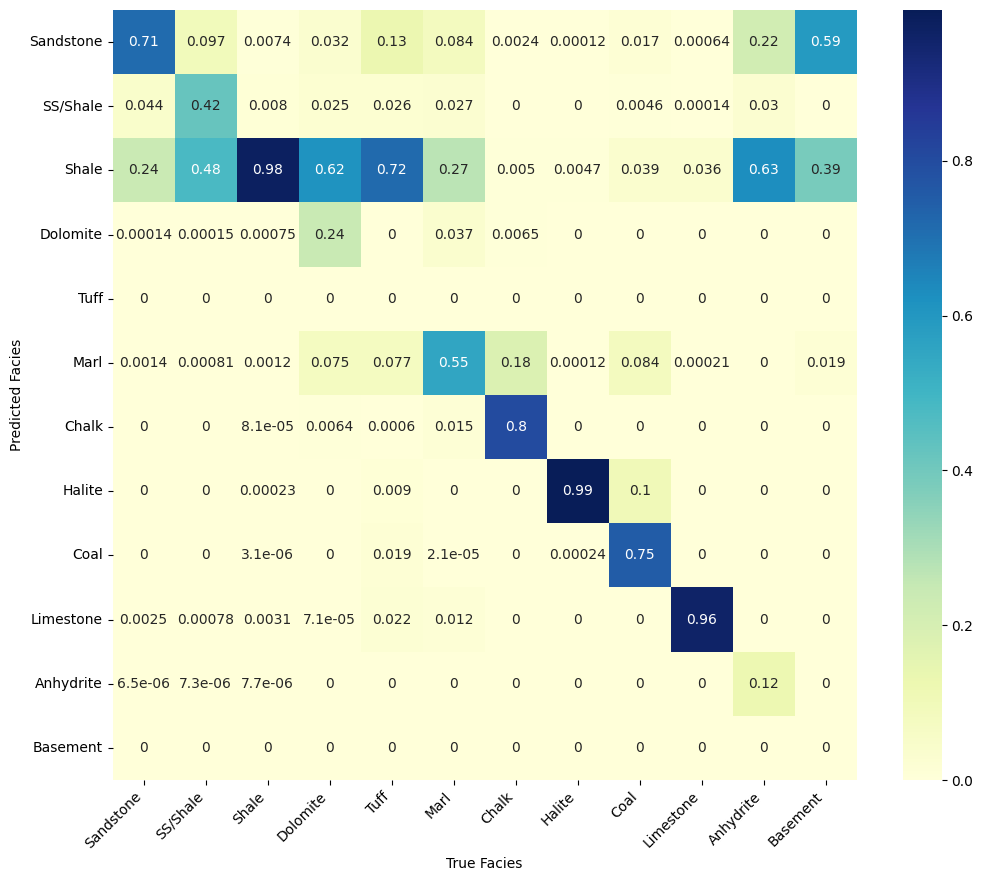

In [98]:
confusion_matrix_facies(train_pred.reset_index(drop=True).values, 
                        trainlitho.values, facies_labels=list(lithofacies_names.values()));

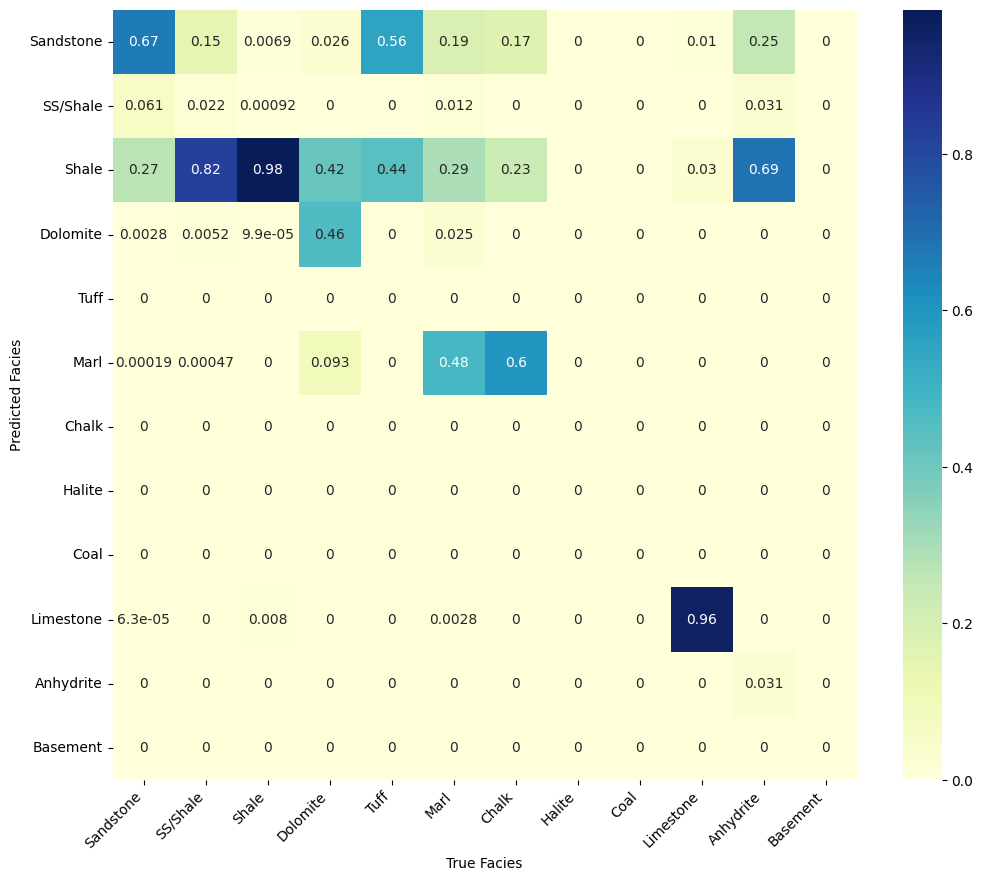

In [99]:
confusion_matrix_facies(valid_pred.reset_index(drop=True).values, 
                        validlitho.values, facies_labels=list(lithofacies_names.values()));

We may find some insights into why some classes are predicted more or less accurately than others by looking at some detailed crossplots

In [100]:
iwell = 0
welldata = validdata[validdata['WELL'] == validnwellcodes1[validwellnames[iwell]]]

las = lasio.LASFile()
numerical_columns = validdata.select_dtypes(include=np.number).columns
for log in numerical_columns:
    logvalues = welldata[log].values.astype('float')
    logvalues[logvalues==-9999.] = np.nan
    las.add_curve(log, logvalues)
las.write('../../data/welllogs/%s_predicted.las' %  validwellnames[iwell].replace('/', '_'), version=1.2)

logs = Logs('../../data/welllogs/%s_predicted.las' %  validwellnames[iwell].replace('/', '_'))

fig, ax, scatax, cbar = \
    logs.visualize_crossplot('RHOB', 'GR', 
                             curvecolor='FORCE_2020_LITHOFACIES_LITHOLOGY', 
                             thresh2=150,
                             cmap=lithofacies_colors.values(),                                     
                             cbar=True, clims=[0,nlithofacies-1],
                             cbarlabels=list(lithofacies_names.values()), 
                             figsize=(12,5));

AttributeError: 'LASFile' object has no attribute 'add_curve'

Let's now drop the two added columns to the validdata dataframe to be able to use it again with another model

In [101]:
validdata = validdata.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY',
                            'FORCE_2020_LITHOFACIES_LITHOLOGY_PRED'], axis=1)

### Deep Feedforward neural network

Let's start by removing so of the rows from our data so that we have less unbalanced lithofacies. We will see that this makes a difference. Especially with Neural Networks it is important to avoid very unbalanced classes.

In [102]:
traindata_balanced, trainlitho_balanced = traindata.copy(), trainlitho.copy()
    
for ifacies in [2, 0, 1, 5, 3, 9, 6, 7]:
    traindata_balanced.reset_index(drop=True, inplace=True)
    trainlitho_balanced.reset_index(drop=True, inplace=True)

    trainlitho_facies = np.where(trainlitho_balanced == ifacies)[0]
    ifacies_drop = np.random.permutation(trainlitho_facies)[5000:]
    
    traindata_balanced = traindata_balanced.drop(index=ifacies_drop)
    trainlitho_balanced = trainlitho_balanced.drop(index=ifacies_drop)

In [103]:
print('Percentages of original lithofacies:')
trainlitho.value_counts() / trainlitho.shape[0] * 100

Percentages of original lithofacies:


FORCE_2020_LITHOFACIES_LITHOLOGY
2     61.621957
0     14.502349
1     13.044553
5      4.591593
3      2.675594
9      1.323159
6      0.841933
7      0.778167
10     0.349905
4      0.158229
8      0.102802
11     0.009759
Name: count, dtype: float64

In [104]:
print('Percentages of rebalanced lithofacies:')
trainlitho_balanced.value_counts() / trainlitho_balanced.shape[0] * 100

Percentages of rebalanced lithofacies:


FORCE_2020_LITHOFACIES_LITHOLOGY
2     10.740908
0     10.740908
1     10.740908
5     10.740908
9     10.740908
3     10.740908
6     10.740908
7     10.740908
10     7.933235
4      3.587463
8      2.330777
11     0.221263
Name: count, dtype: float64

In [105]:
# Scaling pre-processing
scaler = StandardScaler()
scaler.fit(traindata)

# Define Train Set
X_train = torch.from_numpy(scaler.transform(traindata_balanced.values)).float()
y_train = torch.from_numpy(trainlitho_balanced.values).long()
train_dataset = TensorDataset(X_train, y_train)

# Define Valid Set
X_valid = torch.from_numpy(scaler.transform(validdata.values)).float()
y_valid = torch.from_numpy(validlitho.values).long()
valid_dataset = TensorDataset(X_valid, y_valid)

# Use Pytorch's functionality to load data in batches.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [108]:
set_seed(42)
network = nn.Sequential(nn.Linear(traindata.shape[1], 32, bias=True), 
                        nn.ReLU(),
                        nn.Linear(32, 64, bias=True), 
                        nn.ReLU(),
                        nn.Linear(64, 128, bias=True), 
                        nn.ReLU(),
                        nn.Linear(128, nlithofacies, bias=True)).to(device)
network.apply(init_weights)

Sequential(
  (0): Linear(in_features=22, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=12, bias=True)
)

In [109]:
train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = \
    classification(network, train_loader, valid_loader, epochs=100, device=device)

Epoch 0, Training Loss 1.39, Training Accuracy 0.55, Validation Loss 1.58, Test Accuracy 0.57
Epoch 10, Training Loss 0.74, Training Accuracy 0.76, Validation Loss 1.25, Test Accuracy 0.64
Epoch 20, Training Loss 0.71, Training Accuracy 0.77, Validation Loss 1.33, Test Accuracy 0.62
Epoch 30, Training Loss 0.69, Training Accuracy 0.77, Validation Loss 1.48, Test Accuracy 0.60
Epoch 40, Training Loss 0.69, Training Accuracy 0.78, Validation Loss 1.32, Test Accuracy 0.61
Epoch 50, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.25, Test Accuracy 0.65
Epoch 60, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.36, Test Accuracy 0.61
Epoch 70, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.28, Test Accuracy 0.66
Epoch 80, Training Loss 0.67, Training Accuracy 0.78, Validation Loss 1.34, Test Accuracy 0.65
Epoch 90, Training Loss 0.67, Training Accuracy 0.78, Validation Loss 1.29, Test Accuracy 0.66


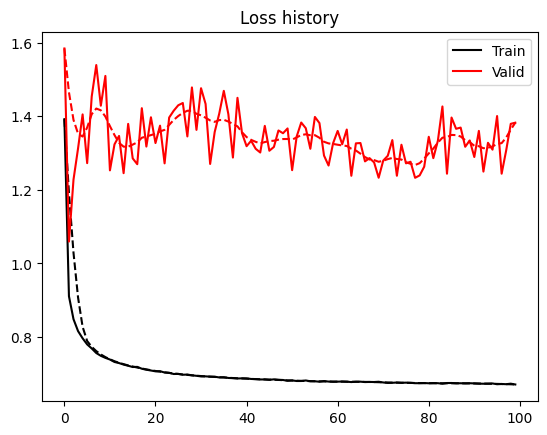

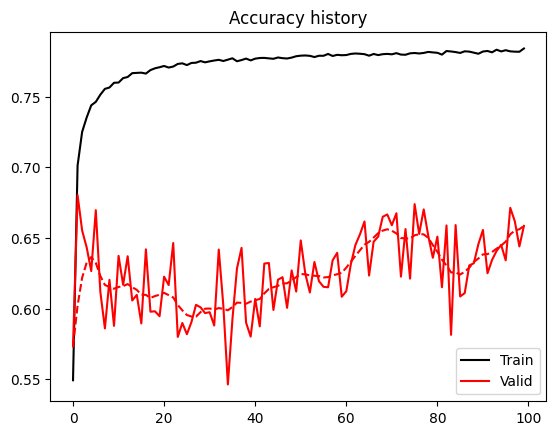

In [110]:
plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(filtfilt(np.ones(5)/5, 1, train_loss_history), '--k')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.plot(filtfilt(np.ones(5)/5, 1, valid_loss_history), '--r')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.plot(filtfilt(np.ones(5)/5, 1, valid_acc_history), '--r')
plt.title('Accuracy history')
plt.legend();

In [111]:
network.eval()
network.to(device)
with torch.no_grad():    
    y_train_pred = nn.Softmax(dim=1)(network(X_train.to(device)))
    y_valid_pred = nn.Softmax(dim=1)(network(X_valid.to(device)))
print("Train set accuracy: ", accuracy_score(y_train, np.argmax(y_train_pred.detach().cpu().numpy(), axis=1)))
print("Test set accuracy: ", accuracy_score(y_valid, np.argmax(y_valid_pred.detach().cpu().numpy(), axis=1)))

Train set accuracy:  0.7844299800219114
Test set accuracy:  0.6582871343911298


In [112]:
train_nnpred = np.argmax(y_train_pred.detach().cpu().numpy(), axis=1)
valid_nnpred = np.argmax(y_valid_pred.detach().cpu().numpy(), axis=1)

In [113]:
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY']= validlitho
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY_PRED'] = valid_pred
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY_NNPRED'] = valid_nnpred

In [114]:
show_evaluation(train_nnpred, trainlitho_balanced)

Force score is: -0.5867596829284011
Accuracy is: 0.7844299800219114
F1 is: 0.7882085984849836


In [115]:
show_evaluation(valid_nnpred, validlitho)

Force score is: -0.8657240054917363
Accuracy is: 0.6582871343911298
F1 is: 0.6349926099074916


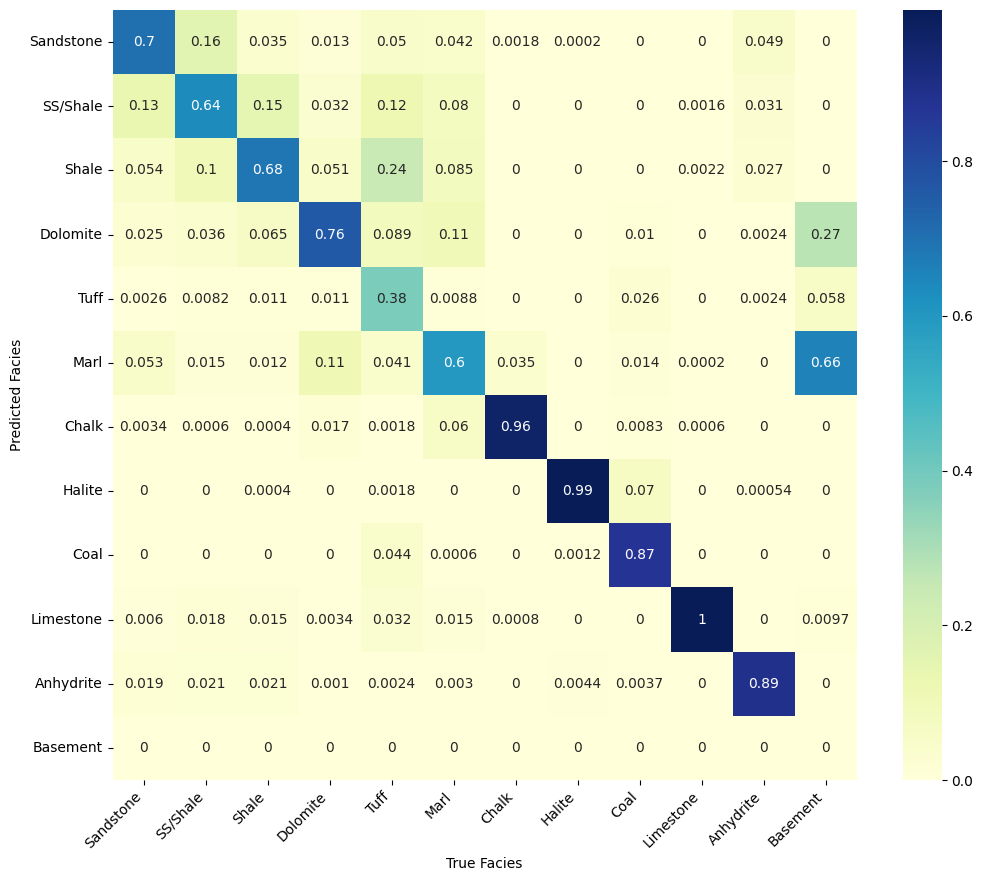

In [116]:
confusion_matrix_facies(train_nnpred, trainlitho_balanced.values, 
                        facies_labels=list(lithofacies_names.values()));

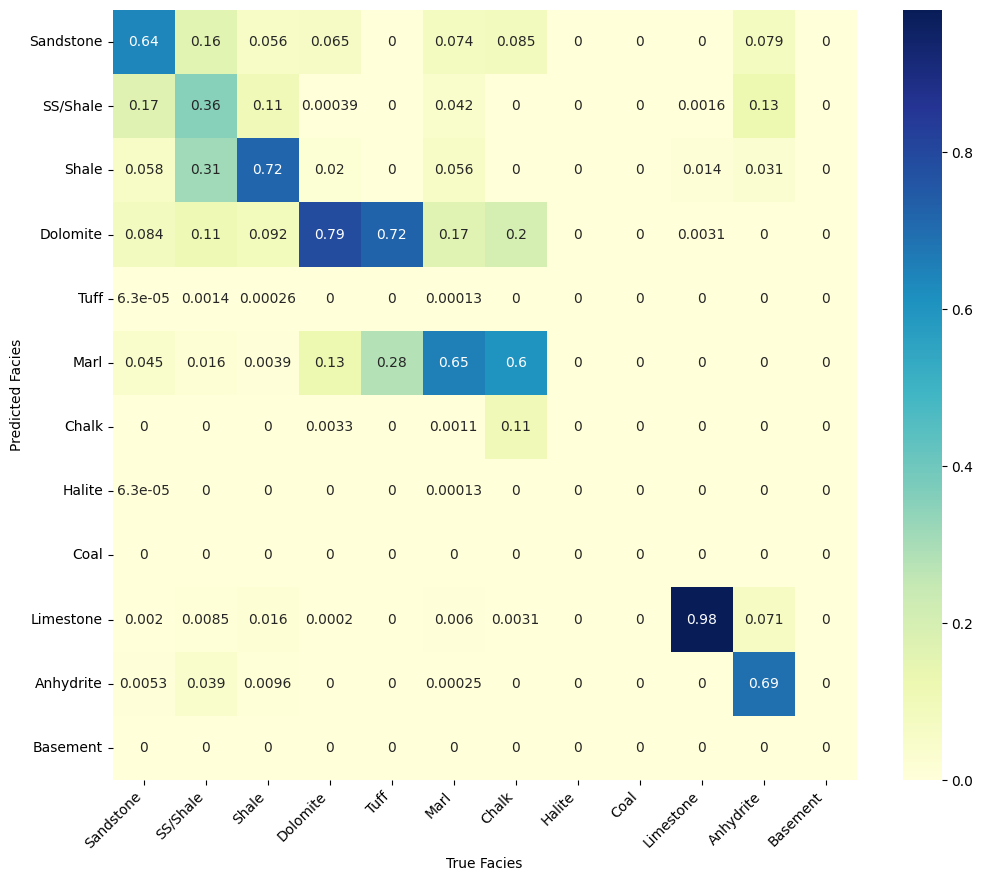

In [117]:
confusion_matrix_facies(valid_nnpred, validlitho.values, 
                        facies_labels=list(lithofacies_names.values()));

There is no significant improvement in the performance of the classifier even after having DTS as an extra feature to use. 